In [1]:
import torch
import numpy as np
from torchvision.transforms import transforms as T
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
sys.path.append('..')
sys.path.append('../dataset_loader')
sys.path.append('../model')
from config import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

from dataset_loader.image_loader import *
from model.resunet import *
from utils import *

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [4]:
for ix,m in enumerate(os.listdir('../model_results/')):
    print(ix,m)

0 c-resunt_y_ae_no_binary.h5
1 c-resunet_red.h5
2 c-resunt_y_few_shot.h5
3 c-resunet_yellow.h5
4 c-resunet_red_ft_1_layer_yellow.h5
5 c-resunt_y_ae_ft_last_layer.h5
6 c-resunet_y_ae.h5


In [5]:
model_name = os.listdir('../model_results/')[6]
print(model_name)

c-resunet_y_ae.h5


In [6]:
from_ae = True

In [7]:
if from_ae:
    resume_path = ModelResults + model_name 
    model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start=16, n_out=1).to(device))

    layers_to_remove = ['module.head.conv2d.weight', 'module.head.conv2d.bias']
    layers_to_rename = ['module.head.conv2d_binary.weight', 'module.head.conv2d_binary.bias']
    checkpoint_file = torch.load(resume_path)
    for k in list(checkpoint_file.keys()):
        if k in layers_to_remove:
            checkpoint_file.pop(k)
    for k in list(checkpoint_file.keys()):
        if k in layers_to_rename:
            checkpoint_file[k.replace("_binary", "")] = checkpoint_file.pop(k)
    model.load_state_dict(checkpoint_file, strict=False)  
    
else:
    model = nn.DataParallel(c_resunet(arch='c-ResUnetVAE', n_features_start = 16, n_out = 1,
            pretrained = False, progress= True)).to(device)
    model.load_state_dict(torch.load('../model_results/{}'.format(model_name)))

Initializing conv2d weights with Kaiming He normal


In [8]:
test = True
dataset = 'yellow'

In [9]:
transform = T.Compose([T.Lambda(lambda x: x * 1. / 255),
                       T.ToTensor(),
                       #T.Resize((1040,1400))
                      #T.Lambda(lambda x: x.permute(2, 0, 1))
                       ])

In [10]:
if dataset == 'yellow':
    priority_list = ['254.tiff', '275.tiff', '81.tiff', '278.tiff', '279.tiff', '281.tiff', '273.tiff'
                    ,'50.tiff']
    cells_images = CellsLoader(root + "/DATASET/test/all_images/images/",
                               root + "/DATASET/test/all_masks/masks/", 
                               val_split=0.3, transform = transform, test = test, 
                               priority_list=priority_list)
elif dataset == 'red':
    priority_list = []
    cells_images = CellsLoader(root + "/DATASET/fine_tuning/red/test/all_images/images/",
                               root + "/DATASET/fine_tuning/red/test/all_masks/masks/", 
                               val_split=0.3, transform = transform, test = test)

#cells_images = CellsLoader(root + "/DATASET/train_val/crop_augmented/images/",
#                           root + "/DATASET/train_val/crop_augmented/masks/", 
#                           val_split=0.3, transform = transform, ae = ae, test = False)

In [11]:
batch_size = 8
test_loader = DataLoader(cells_images, batch_size=batch_size)

In [12]:
x, y = next(iter(test_loader))

In [13]:
x.size()

torch.Size([8, 3, 1200, 1600])

In [14]:
y.size()

torch.Size([8, 3, 1200, 1600])

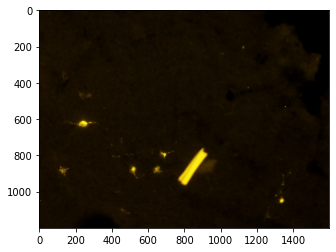

In [15]:
plt.imshow(x[0].permute(1,2,0))

In [16]:
model.eval()
with torch.no_grad():
    heatmap = model(x.to(device))
    #heatmap = 1 - heatmap

In [17]:
heatmap.shape

torch.Size([8, 1, 1200, 1600])

In [18]:
save = True

path alredy exixts
path alredy exixts
path alredy exixts
path alredy exixts
path alredy exixts
path alredy exixts
path alredy exixts
path alredy exixts


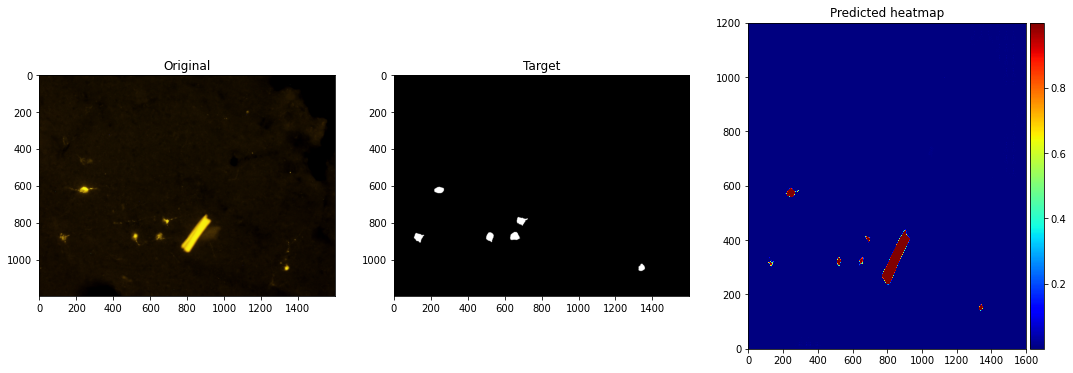

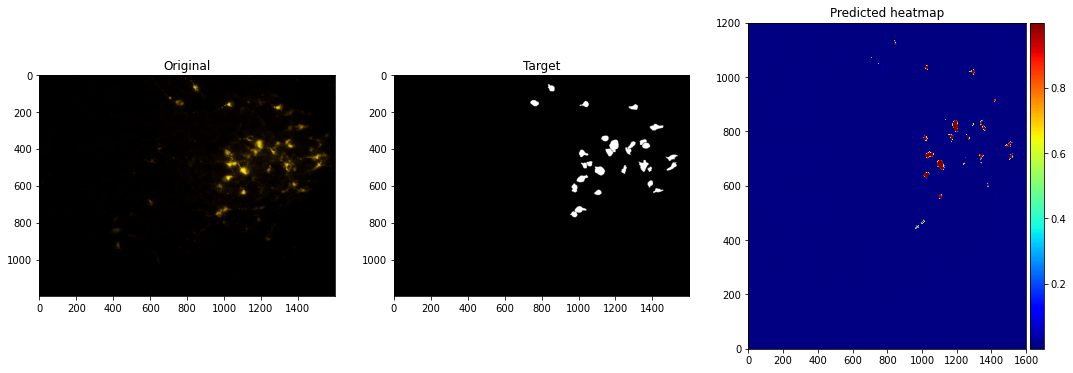

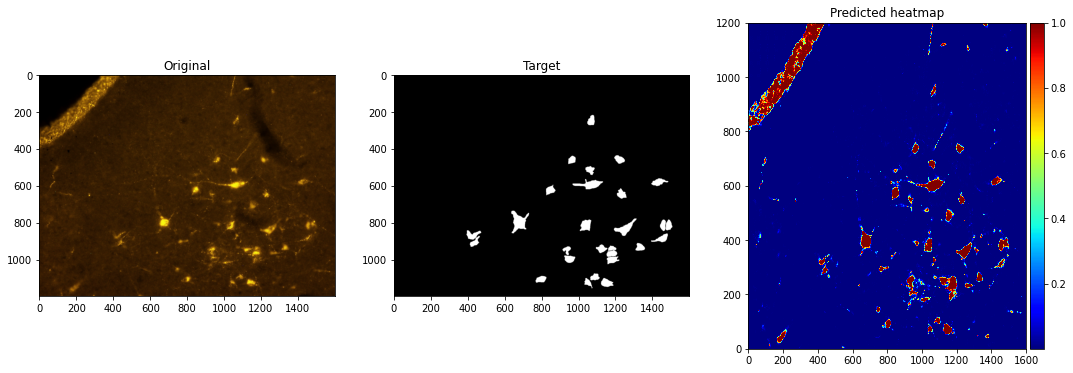

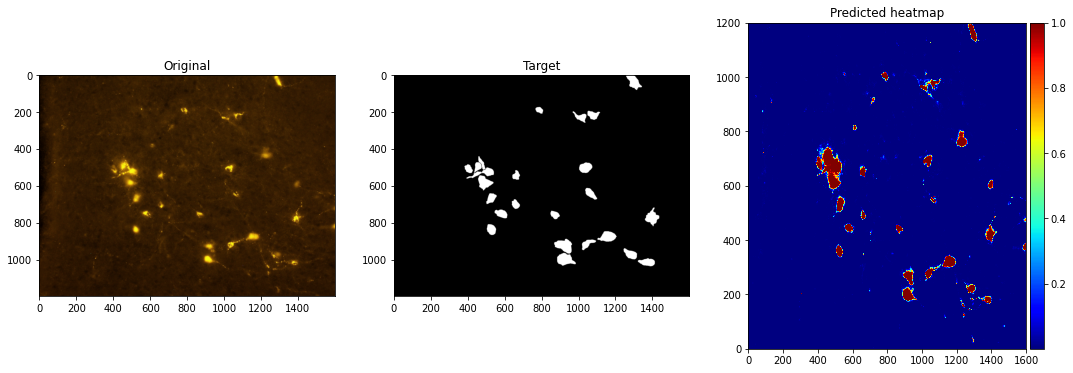

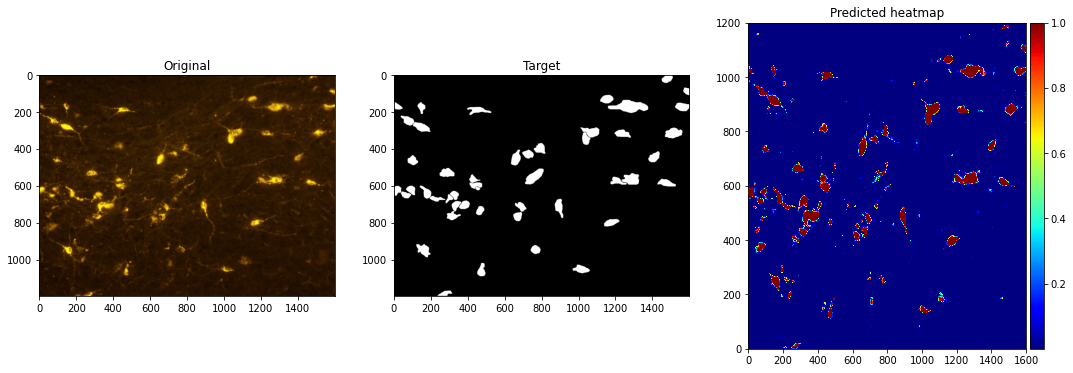

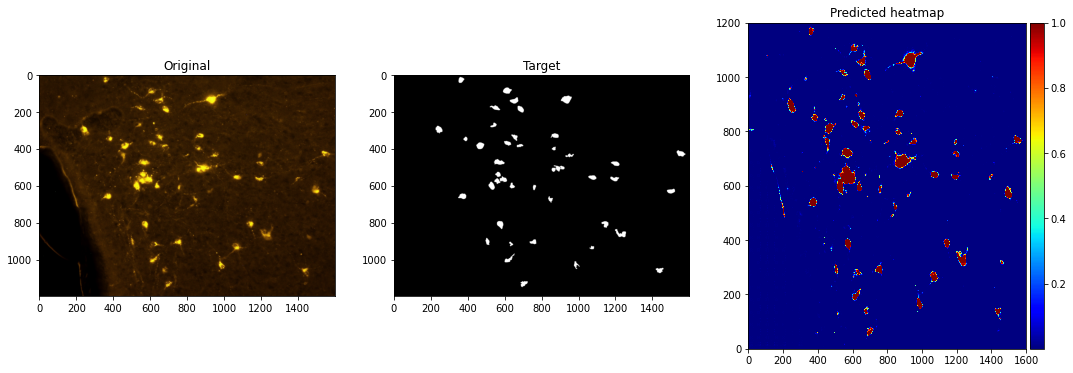

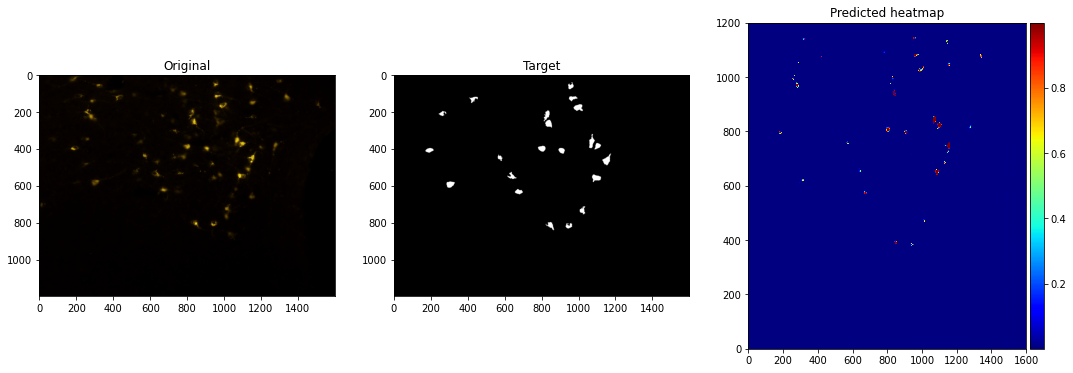

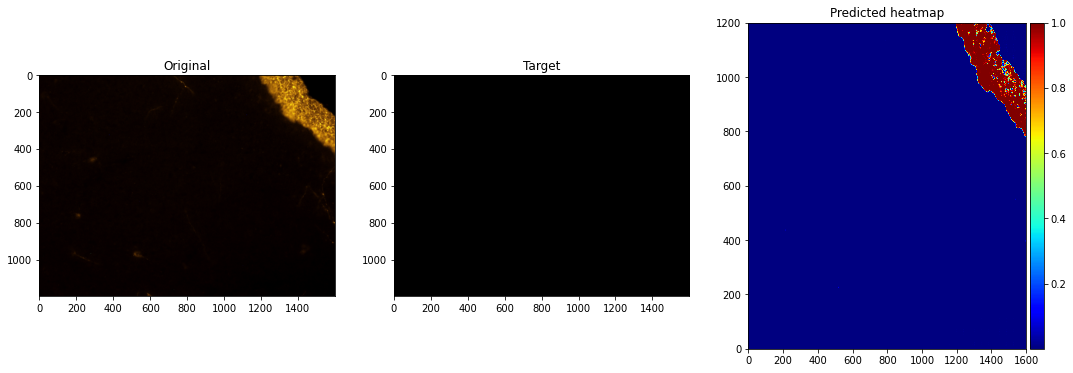

In [19]:
for i in range(heatmap.size()[0]):
    
#     print(test_ids[i+start])
    original = x[i].permute(1,2,0)
    target = y[i].permute(1,2,0)
    heat_map = heatmap[i]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
       
    im = axes[0].imshow(original)
    axes[0].set_title('Original')

    im = axes[1].imshow(np.squeeze(target), cmap='gray')
    axes[1].set_title('Target')

    im = axes[2].pcolormesh(np.flipud(heat_map.cpu().detach().squeeze()), cmap='jet')
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    axes[2].set_title('Predicted heatmap') 
    
    if save:
        if os.path.exists('../figure_results/{}/{}'.format(model_name.split('.')[0], dataset)):
            print('path alredy exixts')
        else:
            os.makedirs('../figure_results/{}/{}'.format(model_name.split('.')[0], dataset))
        
        plt.savefig('../figure_results/{}/{}/{}_{}.png'.format(model_name.split('.')[0], \
                                                               dataset, model_name.split('.')[0],i))